In [4]:
from IPython.display import display
from dataclasses import dataclass
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset
from pathlib import Path
from typing import Dict,List,Tuple,Union

In [5]:
data_dir="drive_action_output"
data_dir

'drive_action_output'

In [6]:
chat_file=Path(data_dir).joinpath("drive_action_train.json")
chat_data=pd.read_json(path_or_buf=chat_file)
chat_data.shape

(5000, 3)

In [7]:
chat_data.iloc[10]

id                         d9d28bde-1f4b-11f0-b3a2-644ed76caecb_10
image            [images/10_image_0.jpg, images/10_image_1.jpg,...
conversations    [{'from': 'human', 'value': 'View 1: <image>
V...
Name: 10, dtype: object

In [8]:
chat_data.iloc[10]['conversations']

[{'from': 'human',
  'value': 'View 1: <image>\nView 2: <image>\nView 3: <image>\n106 meters ahead, the navigation indicates to drive towards the right front. There are four lanes ahead, and the lane attributes from left to right are straight, straight, straight, and straight. Please drive towards the right front fork. The road surface arrow on the current rightmost lane indicates that vehicles can enter the right front fork.\nPlease answer True or False.'},
 {'from': 'gpt', 'value': 'True'}]

In [9]:
chat_data.iloc[10]['image']

['images/10_image_0.jpg', 'images/10_image_1.jpg', 'images/10_image_2.jpg']

In [10]:
image_dir=Path(data_dir).joinpath("images")
image_dir

PosixPath('drive_action_output/images')

In [11]:
image_list = chat_data.iloc[10]['image']

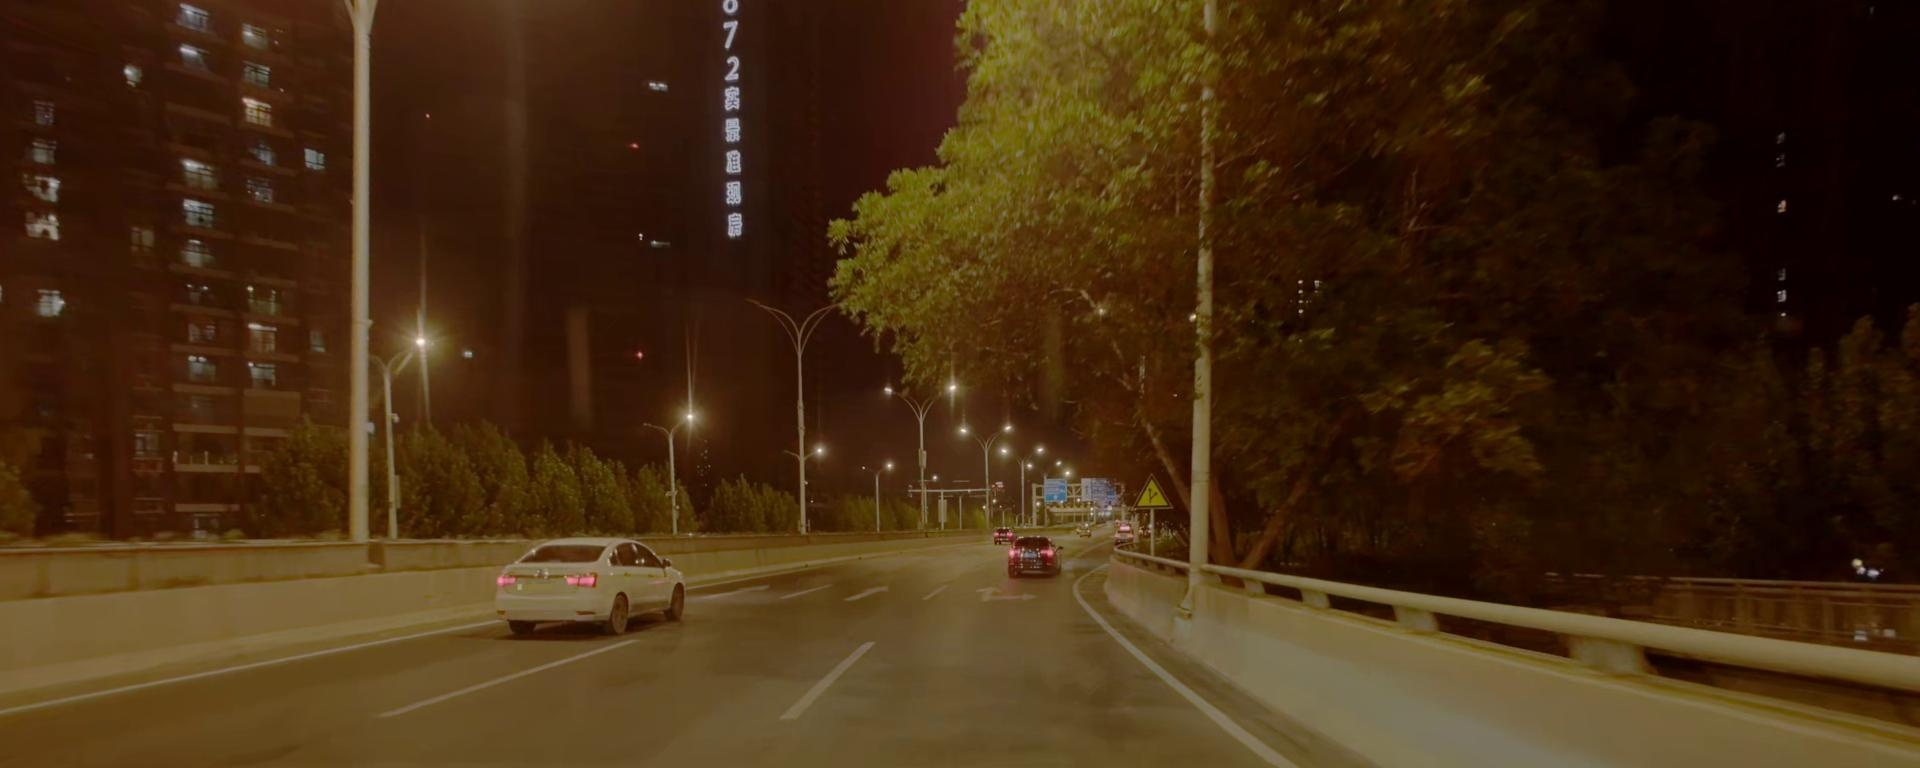

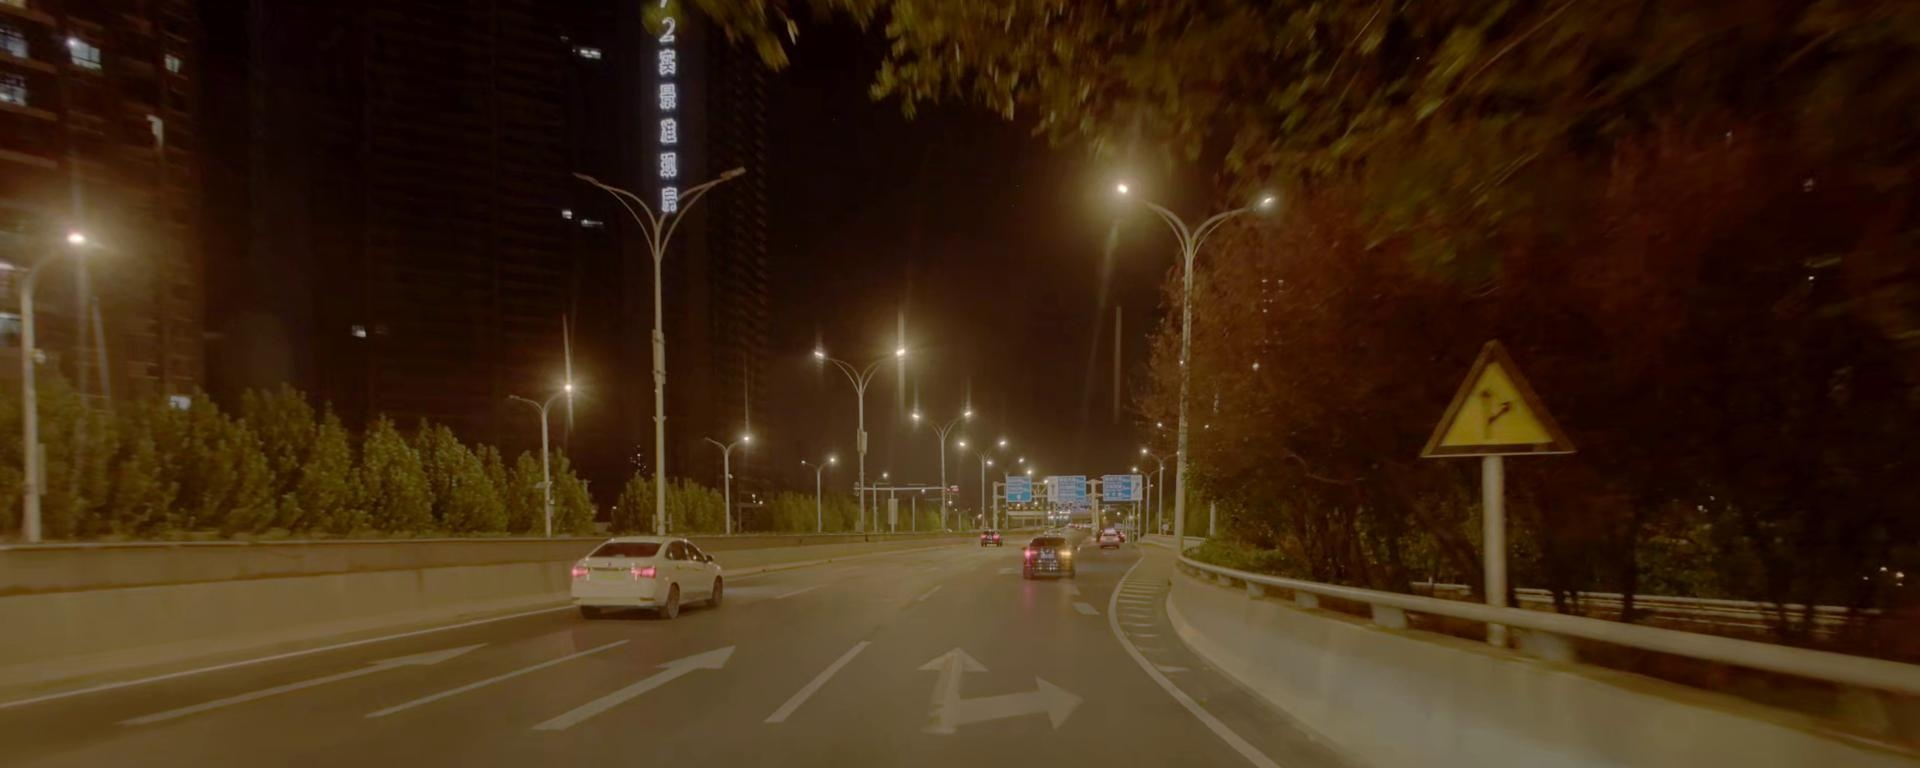

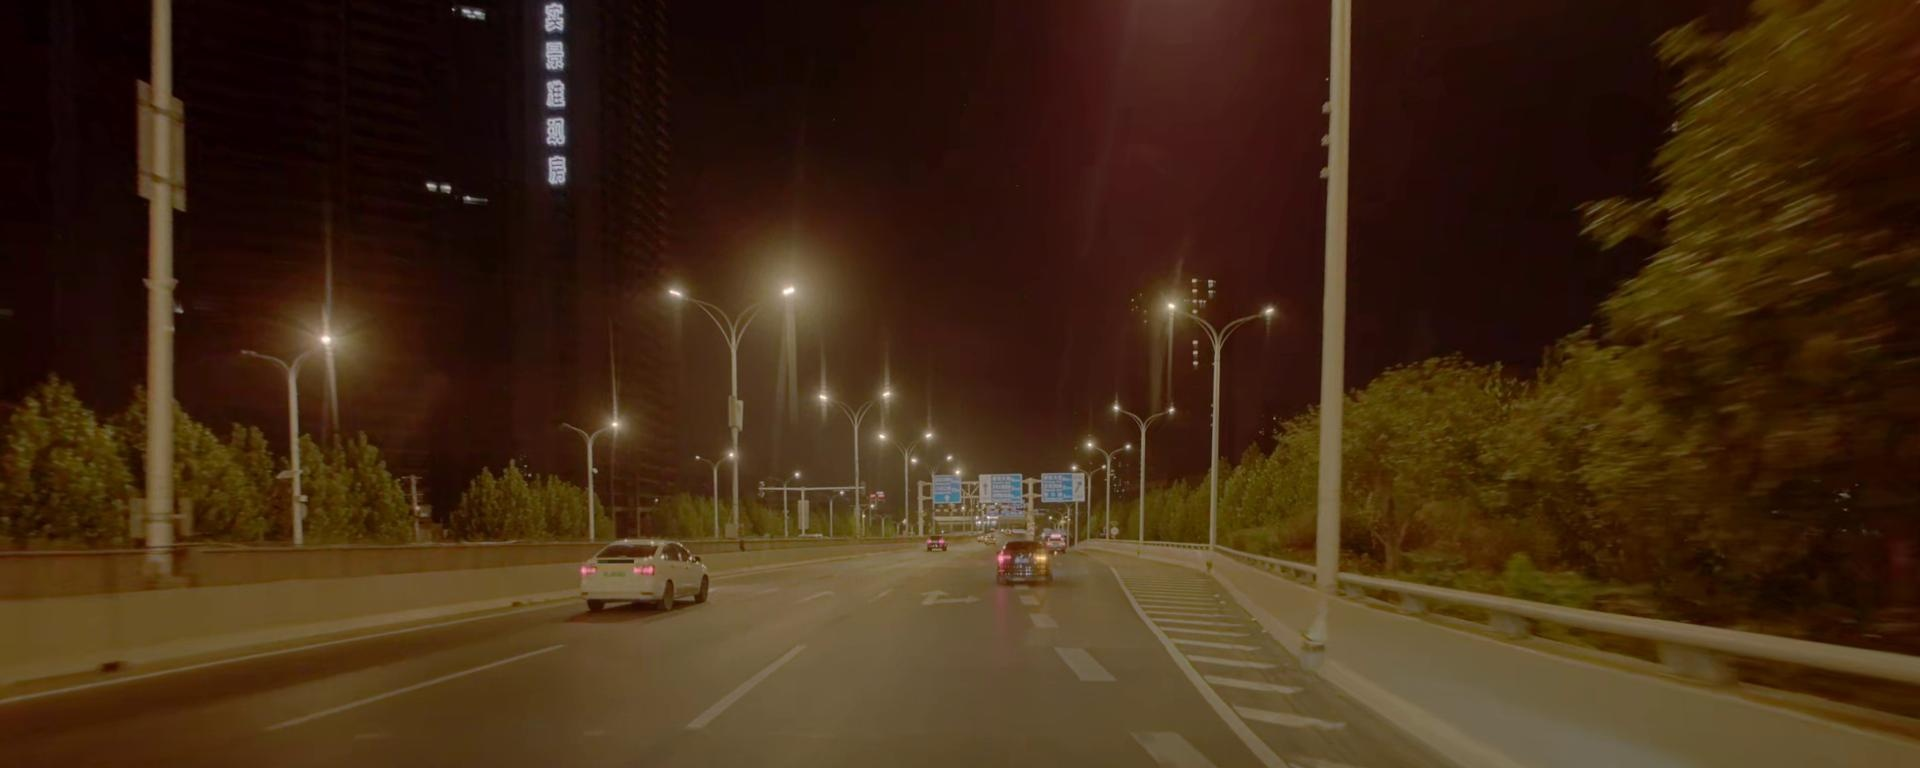

In [12]:
for img_name in image_list:
    img_path = image_dir / Path(img_name).name  # 取文件名避免重复目录
    display(Image.open(img_path))

In [13]:
q=chat_data.iloc[10]['conversations'][0]['value']
a=chat_data.iloc[10]['conversations'][1]['value']

q,a

('View 1: <image>\nView 2: <image>\nView 3: <image>\n106 meters ahead, the navigation indicates to drive towards the right front. There are four lanes ahead, and the lane attributes from left to right are straight, straight, straight, and straight. Please drive towards the right front fork. The road surface arrow on the current rightmost lane indicates that vehicles can enter the right front fork.\nPlease answer True or False.',
 'True')

In [14]:
class LlavaDataset(Dataset):
    def __init__(self, dataset_dir: str) -> None:
        super().__init__()
        self.chat_data, self.image_dir = self.build_dataset(dataset_dir)

    def build_dataset(self, data_dir: str) -> Tuple[List[Dict], Path]:
        data_dir = Path(data_dir)
        chat_file = data_dir.joinpath("drive_action_train.json")
        image_dir = data_dir.joinpath("images")

        chat_data = pd.read_json(chat_file).to_dict(orient="records")

        return chat_data, image_dir

    def __len__(self):
        return len(self.chat_data)

    def __getitem__(self, index) -> Tuple[str, str, Path]:
        cur_data = self.chat_data[index]
        conversations = cur_data.get("conversations")

        human_input = conversations[0].get("value")
        chatbot_output = conversations[1].get("value")

        # --- 修改部分：支持多个图片 ---
        image_list = cur_data.get("image")   # 可能是 list 或 str
        image_paths = []

        if isinstance(image_list, list):
            for img in image_list:
                # img 是类似 "images/10_image_0.jpg"，取文件名
                img_path = self.image_dir / Path(img).name
                image_paths.append(img_path)
        else:
            # 单图片情况（兼容旧数据）
            image_paths = [self.image_dir / Path(image_list).name]
        return human_input, chatbot_output, image_paths

In [15]:
test_llavadataset=LlavaDataset(dataset_dir=data_dir)

In [16]:
len(test_llavadataset)

5000

In [17]:
test_llavadataset[1234]

('View 1: <image>\nView 2: <image>\nView 3: <image>\nThe navigation indicates a left-turn U-turn. As shown in the picture, please determine the types and number of traffic signals ahead in your lane.\nA. One left-turn arrow signal and one straight circular signal\nB. Two straight circular signals\nC. One left-turn arrow signal and two straight circular signals\nD. Only one straight circular signal.\nPlease answer with the option letter only (A/B/C/D).',
 'C',
 [PosixPath('drive_action_output/images/1234_image_0.jpg'),
  PosixPath('drive_action_output/images/1234_image_1.jpg'),
  PosixPath('drive_action_output/images/1234_image_2.jpg')])

In [18]:
image_paths = test_llavadataset[1234][2]
image_paths



[PosixPath('drive_action_output/images/1234_image_0.jpg'),
 PosixPath('drive_action_output/images/1234_image_1.jpg'),
 PosixPath('drive_action_output/images/1234_image_2.jpg')]

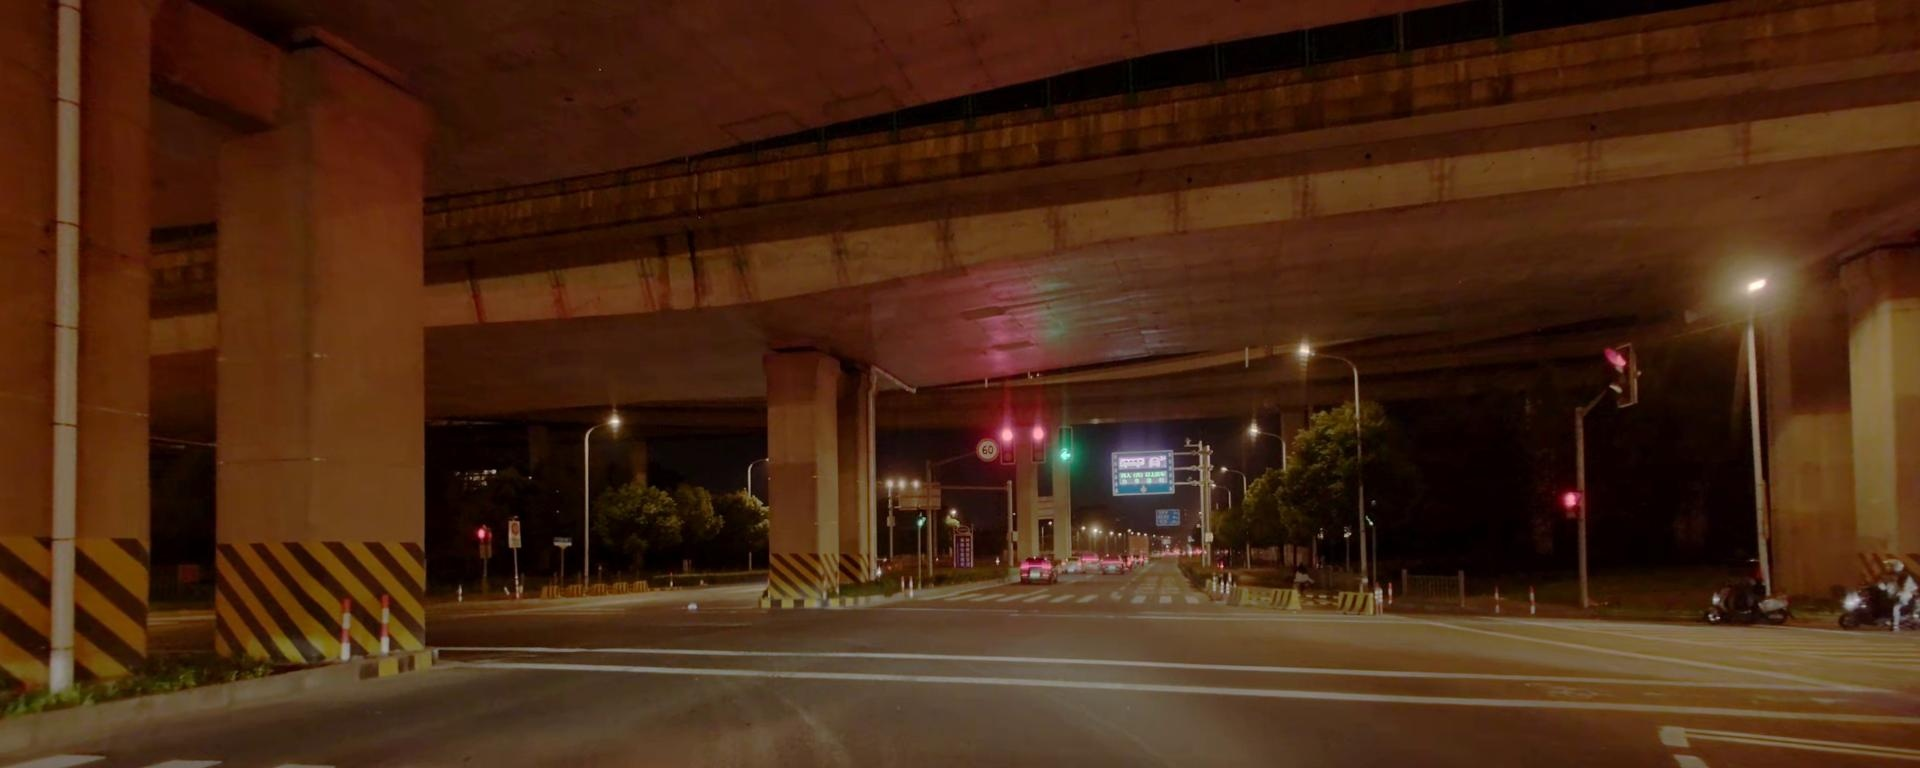

In [19]:
p=image_paths[2]
display(Image.open(p))


In [20]:
from transformers import LlavaProcessor,AutoProcessor
llava_model_name_or_path="llava_onevision"
llava_processor=AutoProcessor.from_pretrained(pretrained_model_name_or_path=llava_model_name_or_path)

The tokenizer you are loading from 'llava_onevision' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


In [21]:
test002=test_llavadataset[1234]
test002

('View 1: <image>\nView 2: <image>\nView 3: <image>\nThe navigation indicates a left-turn U-turn. As shown in the picture, please determine the types and number of traffic signals ahead in your lane.\nA. One left-turn arrow signal and one straight circular signal\nB. Two straight circular signals\nC. One left-turn arrow signal and two straight circular signals\nD. Only one straight circular signal.\nPlease answer with the option letter only (A/B/C/D).',
 'C',
 [PosixPath('drive_action_output/images/1234_image_0.jpg'),
  PosixPath('drive_action_output/images/1234_image_1.jpg'),
  PosixPath('drive_action_output/images/1234_image_2.jpg')])

In [22]:
test002[0]

'View 1: <image>\nView 2: <image>\nView 3: <image>\nThe navigation indicates a left-turn U-turn. As shown in the picture, please determine the types and number of traffic signals ahead in your lane.\nA. One left-turn arrow signal and one straight circular signal\nB. Two straight circular signals\nC. One left-turn arrow signal and two straight circular signals\nD. Only one straight circular signal.\nPlease answer with the option letter only (A/B/C/D).'

In [23]:
test002[1]

'C'

In [24]:
test002[2]

[PosixPath('drive_action_output/images/1234_image_0.jpg'),
 PosixPath('drive_action_output/images/1234_image_1.jpg'),
 PosixPath('drive_action_output/images/1234_image_2.jpg')]

In [25]:
type(test002[2])

list

In [26]:
print(test002[2], type(test002[2]))
for i, p in enumerate(test002[2]):
    print(i, p, type(p))


[PosixPath('drive_action_output/images/1234_image_0.jpg'), PosixPath('drive_action_output/images/1234_image_1.jpg'), PosixPath('drive_action_output/images/1234_image_2.jpg')] <class 'list'>
0 drive_action_output/images/1234_image_0.jpg <class 'pathlib.PosixPath'>
1 drive_action_output/images/1234_image_1.jpg <class 'pathlib.PosixPath'>
2 drive_action_output/images/1234_image_2.jpg <class 'pathlib.PosixPath'>


In [27]:
print(llava_processor.chat_template)


{% set image_count = namespace(value=0) %}{% set video_count = namespace(value=0) %}{% for message in messages %}{% if loop.first and message['role'] != 'system' %}<|im_start|>system
You are a helpful assistant.<|im_end|>
{% endif %}<|im_start|>{{ message['role'] }}
{% if message['content'] is string %}{{ message['content'] }}<|im_end|>
{% else %}{% for content in message['content'] %}{% if content['type'] == 'image' or 'image' in content or 'image_url' in content %}{% set image_count.value = image_count.value + 1 %}{% if add_vision_id %}Picture {{ image_count.value }}: {% endif %}<|vision_start|><|image_pad|><|vision_end|>{% elif content['type'] == 'video' or 'video' in content %}{% set video_count.value = video_count.value + 1 %}{% if add_vision_id %}Video {{ video_count.value }}: {% endif %}<|vision_start|><|video_pad|><|vision_end|>{% elif 'text' in content %}{{ content['text'] }}{% endif %}{% endfor %}<|im_end|>
{% endif %}{% endfor %}{% if add_generation_prompt %}<|im_start|>assi

In [28]:

@dataclass
class QaImageOutput:
    input_ids: torch.Tensor
    labels: torch.Tensor
    pixel_values: torch.Tensor
    image_sizes: torch.Tensor

def build_qaimage(processor: AutoProcessor, 
                  q_text_from_json: str,  # 这里传入你 JSON 里的 "View 1: <image>..."
                  answer: str, 
                  image_paths: List[Union[str, Path]]) -> QaImageOutput:
    
    # 1. System Prompt
    system_prompt = (
        "You are an autonomous driving assistant. "
        "Analyze the multi-view images and answer the user's question accurately."
    )

    # 2. 动态构建 "官方推荐" 的 List 格式内容
    # ------------------------------------------------------------------
    # 这一步就是为了让 Apply Chat Template 走到 "type": "image" 的分支
    # 从而自动生成 <|vision_start|> 等 OneVision 专属 token
    # ------------------------------------------------------------------
    
    user_content_list = []
    
    # A. 放入图片 (Image)
    # 官方格式要求：先放图片对象
    for _ in image_paths:
        user_content_list.append({"type": "image"})
    
    # B. 放入文本 (Text)
    # 既然我们要用官方格式，这里的文本里就不需要 "<image>" 占位符了
    # 我们把 JSON 里的 "<image>" 删掉，只保留 "View 1:", "View 2:" 这种文字描述
    # 这样模型会看到： [图片1][图片2][图片3] "View 1: \nView 2: \n..."
    # 注意：OneVision 会自动把图片放在前面，或者我们可以手动控制顺序，但最简单的官方写法是图片在前。
    
    # 清洗文本：把 <image> 删掉，因为 type: image 已经代替了它
    clean_q_text = q_text_from_json.replace("<image>", "").strip()
    
    user_content_list.append({"type": "text", "text": clean_q_text})

    # 3. 构建 Messages
    messages = [
        {"role": "system", "content": [{"type": "text", "text": system_prompt}]},
        {"role": "user",   "content": user_content_list}, # <--- 这里传入列表！
    ]

    # 4. 生成 Prompt (不含 Answer)
    # 此时模板会走 else 分支，自动插入 <|vision_start|> 等 token
    prompt_text = processor.tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # 5. 构造完整文本
    full_text = prompt_text + answer + processor.tokenizer.eos_token

    # 6. 加载图片
    raw_images = [Image.open(Path(p)).convert("RGB") for p in image_paths]

    # 7. Processor 处理
    inputs = processor(
        text=full_text,
        images=raw_images,
        return_tensors="pt",
        padding=True,
        truncation=True
    )




    input_ids = inputs["input_ids"][0]
    pixel_values = inputs["pixel_values"][0]
    
    sizes_list = [[img.height, img.width] for img in raw_images]
    image_sizes = torch.tensor(sizes_list)

    # 再次确保它是 [N, 2]
    image_sizes = image_sizes.reshape(-1, 2) 

    # 8. Mask Labels (SFT 逻辑)
    # 计算 prompt 真实长度 (包含展开后的图片 token)
    prompt_inputs = processor(
        text=prompt_text,
        images=raw_images,
        return_tensors="pt",
        padding=True, 
    )
    prompt_len = prompt_inputs["input_ids"].shape[1]

    labels = input_ids.clone()
    if prompt_len < len(labels):
        labels[:prompt_len] = -100
    else:
        labels[:] = -100

    return QaImageOutput(
        input_ids=input_ids,
        labels=labels,
        pixel_values=pixel_values,
        image_sizes=image_sizes
    )

In [29]:
print(type(llava_processor))

<class 'transformers.models.qwen2_5_vl.processing_qwen2_5_vl.Qwen2_5_VLProcessor'>


In [30]:
c=build_qaimage(processor=llava_processor,q_text_from_json=test002[0],answer=test002[1],image_paths=test002[2])
c

QaImageOutput(input_ids=tensor([151644,   8948,    198,  ...,    198,     34, 151645]), labels=tensor([  -100,   -100,   -100,  ...,   -100,     34, 151645]), pixel_values=tensor([-0.6536, -0.6974, -0.7850, -0.8580, -0.9164, -0.9748, -1.0039, -1.0185,
        -1.0623, -1.0769, -1.1061, -1.1061, -1.1207, -1.1207, -0.6098, -0.6390,
        -0.6828, -0.7704, -0.8288, -0.8726, -0.9310, -0.9602, -1.0185, -1.0623,
        -1.0915, -1.1207, -1.1061, -1.1207, -0.5514, -0.5660, -0.5952, -0.6390,
        -0.7120, -0.7558, -0.8142, -0.8580, -0.9602, -1.0185, -1.0623, -1.1061,
        -1.1207, -1.1061, -0.5076, -0.5076, -0.5076, -0.5368, -0.5806, -0.6536,
        -0.6974, -0.7412, -0.8288, -0.8872, -0.9602, -1.0477, -1.0769, -1.1061,
        -0.4638, -0.4784, -0.4784, -0.5076, -0.5222, -0.5952, -0.6244, -0.6682,
        -0.6828, -0.7412, -0.8288, -0.9310, -0.9893, -1.0477, -0.4492, -0.4492,
        -0.4492, -0.4784, -0.4930, -0.5222, -0.5368, -0.5660, -0.5806, -0.6244,
        -0.6828, -0.7704, -0

In [31]:
c.keys()

AttributeError: 'QaImageOutput' object has no attribute 'keys'

In [32]:
type(c)

__main__.QaImageOutput

In [33]:
c.input_ids.shape

torch.Size([5729])

In [34]:
c.labels.shape

torch.Size([5729])

In [ ]:
c.image_sizes.shape

torch.Size([3, 2])

In [ ]:
c.pixel_values.shape

torch.Size([588])

In [49]:
import torch
from typing import List, Dict, Any
from torch.nn.utils.rnn import pad_sequence

class TrainLLavaOneVisionCollator:
    def __init__(self, processor, IGNORE_INDEX: int = -100):
        self.processor = processor
        self.ignore_index = IGNORE_INDEX
        # 获取 pad_token_id，如果模型没有定义，通常默认为 0 或 eos_id
        self.pad_token_id = processor.tokenizer.pad_token_id if processor.tokenizer.pad_token_id is not None else 0

    def __call__(self, features: List) -> Dict[str, torch.Tensor]:
        """
        features: List of tuples/lists, 每一项是 (q_text, a_text, image_paths)
        对应 Dataset __getitem__ 的返回值
        """
        
        input_ids_list = []
        labels_list = []
        pixel_values_list = []
        image_sizes_list = []

        # 1. 逐条处理数据
        for feature in features:
            # 调用我们之前写好的处理函数
            # feature[0]: human_input (包含 View 1: <image>...)
            # feature[1]: gpt_output (True/False/B...)
            # feature[2]: image_paths (列表)
            qaimage_output = build_qaimage(
                processor=self.processor,
                q_text_from_json=feature[0],
                answer=feature[1],
                image_paths=feature[2]
            )

            # 收集结果
            input_ids_list.append(qaimage_output.input_ids)
            labels_list.append(qaimage_output.labels)
            pixel_values_list.append(qaimage_output.pixel_values)
            image_sizes_list.append(qaimage_output.image_sizes)

        # 2. 对文本进行 Padding (补齐长度)
        # 使用 pad_sequence 自动对齐最长序列 (Right Padding 是 SFT 的标准做法)
        final_input_ids = pad_sequence(
            input_ids_list, 
            batch_first=True, 
            padding_value=self.pad_token_id
        )

        final_labels = pad_sequence(
            labels_list, 
            batch_first=True, 
            padding_value=self.ignore_index
        )

        # 3. 生成 Attention Mask
        # 不等于 pad_id 的地方设为 1，等于的地方设为 0
        attention_mask = final_input_ids.ne(self.pad_token_id).long()

        # 4. 处理图片张量 (OneVision 特有逻辑)
        # pixel_values 不再是 [Batch, C, H, W]，而是扁平化的 Patch 序列
        # 所以这里必须用 cat (拼接) 而不是 stack (堆叠)
        # 结果形状: [Total_Patches_In_Batch, Hidden_Dim]
        final_pixel_values = torch.cat(pixel_values_list, dim=0)
        
        # image_sizes 也要拼接
        # 结果形状: [Total_Images_In_Batch, 2]
        final_image_sizes = torch.cat(image_sizes_list, dim=0)

        return {
            "input_ids": final_input_ids,
            "labels": final_labels,
            "attention_mask": attention_mask,
            "pixel_values": final_pixel_values,
            "image_sizes": final_image_sizes
        }

# --- 测试代码 ---
# 假设 test_llavadataset 已经准备好
# 实例化 Collator
tlmc = TrainLLavaOneVisionCollator(processor=llava_processor, IGNORE_INDEX=-100)



In [50]:
# 模拟取两个样本进行 Batch 打包
batch_data = [test002, test_llavadataset[1000]] # 这里我为了方便演示用了同一个变量，实际用 test_dataset[0], test_dataset[1]

# 运行 Collator
d = tlmc(batch_data)

# 打印结果验证
print("Batch Keys:", d.keys())
print("Input IDs shape:", d['input_ids'].shape)       # [Batch, Max_Len]
print("Labels shape:", d['labels'].shape)             # [Batch, Max_Len]
print("Pixel Values shape:", d['pixel_values'].shape) # [Total_Patches, Dim]
print("Image Sizes shape:", d['image_sizes'].shape)   # [Batch * 3, 2]

Batch Keys: dict_keys(['input_ids', 'labels', 'attention_mask', 'pixel_values', 'image_sizes'])
Input IDs shape: torch.Size([2, 5746])
Labels shape: torch.Size([2, 5746])
Pixel Values shape: torch.Size([1176])
Image Sizes shape: torch.Size([6, 2])


In [51]:
# 检查 image_sizes 是否包含高宽两个数值
assert d['image_sizes'].dim() == 2 and d['image_sizes'].shape[1] == 2, \
    f"错误：image_sizes 形状不对！期望 [6, 2]，实际是 {d['image_sizes'].shape}"

print("✅ 校验通过！数据格式完美，可以开始训练！")

✅ 校验通过！数据格式完美，可以开始训练！


In [42]:
d.keys()

dict_keys(['input_ids', 'labels', 'attention_mask', 'pixel_values', 'image_sizes'])

In [44]:
d['input_ids'].shape

torch.Size([2, 5746])

In [45]:
d['labels']

tensor([[  -100,   -100,   -100,  ...,   -100,   -100,   -100],
        [  -100,   -100,   -100,  ...,   -100,     32, 151645]])

In [47]:
d['pixel_values'].shape

torch.Size([1176])

In [53]:
d['attention_mask'].shape

torch.Size([2, 5746])